## **Setup**

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
from tensorflow.keras import layers, datasets

from tqdm.notebook import tqdm
import matplotlib.pylab as plt
from PIL import Image
import os

In [2]:
DEPTH_MULTIPLIER_PREFIX = '0'
DEPTH_MULTIPLIER = 25
IMAGE_SIZE = 128
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)
BATCH_SIZE = 100
NUM_EPOCHS = 20

## **Dataset**

In [3]:
path_train = 'datasets\\data-cifar-10\\train'
path_validation = 'datasets\\data-cifar-10\\validation'

In [4]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, horizontal_flip=True, vertical_flip=True, brightness_range=[0.5, 1.0])
val_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [5]:
image_data = train_image_generator.flow_from_directory(str(path_train), target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE)
image_data_validation = val_image_generator.flow_from_directory(str(path_validation), target_size=IMAGE_SHAPE, batch_size=BATCH_SIZE )

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [6]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (100, 128, 128, 3)
Label batch shape:  (100, 10)


In [7]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(class_names)

['Airplane' 'Automobile' 'Bird' 'Cat' 'Deer' 'Dog' 'Frog' 'Horse' 'Ship'
 'Truck']


## **Download model**

In [8]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_" + DEPTH_MULTIPLIER_PREFIX +  str(DEPTH_MULTIPLIER) + "_" + str(IMAGE_SIZE) +"/feature_vector/4"
print(feature_extractor_url)

https://tfhub.dev/google/imagenet/mobilenet_v1_025_128/feature_vector/4


In [9]:
# Create the feature extractor.
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMAGE_SHAPE+(3,))

In [10]:
# UnFreeze the variables in the feature extractor laye
feature_extractor_layer.trainable = True

## **Add classification head**

In [11]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 256)               218544    
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 221,114
Trainable params: 215,642
Non-trainable params: 5,472
_________________________________________________________________


## **Training procedure**

In [12]:
STEPS_PER_EPOCH = int(np.ceil(image_data.samples/BATCH_SIZE))
print(STEPS_PER_EPOCH)

500


In [13]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH/2,
  decay_rate=0.5,
  staircase=False)

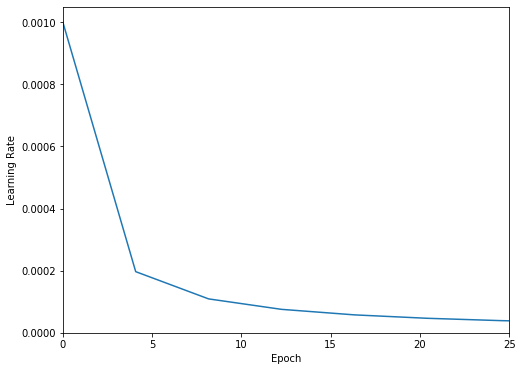

In [14]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlim([0,25])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [15]:
def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [16]:
optimizer = get_optimizer()

In [17]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['accuracy', 'categorical_crossentropy'])

In [18]:
model_name = 'mobilenet_v1_'+ DEPTH_MULTIPLIER_PREFIX + str(DEPTH_MULTIPLIER)+'_'+str(IMAGE_SIZE)+'_epochs_'+str(NUM_EPOCHS)
print(model_name)

mobilenet_v1_025_128_epochs_20


In [19]:
history = model.fit_generator(image_data, epochs=1,
                                steps_per_epoch=STEPS_PER_EPOCH,
                                validation_data=image_data_validation,
                                validation_freq=1)

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 500 steps, validate for 100 steps
500/500 [==============================] - 1589s 3s/step - loss: 0.7385 - accuracy: 0.7603 - categorical_crossentropy: 0.6789 - val_loss: 0.6310 - val_accuracy: 0.7986 - val_categorical_crossentropy: 0.5713


## **Check the predictions**

In [20]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

**Plot the result**

In [21]:
label_id = np.argmax(label_batch, axis=-1)

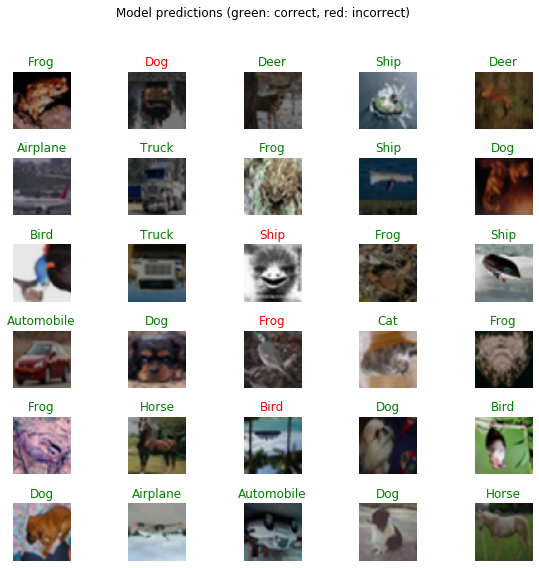

In [22]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")